# Who Kills Who


当前数据基于 150000 局对局。
生成可视化图表...


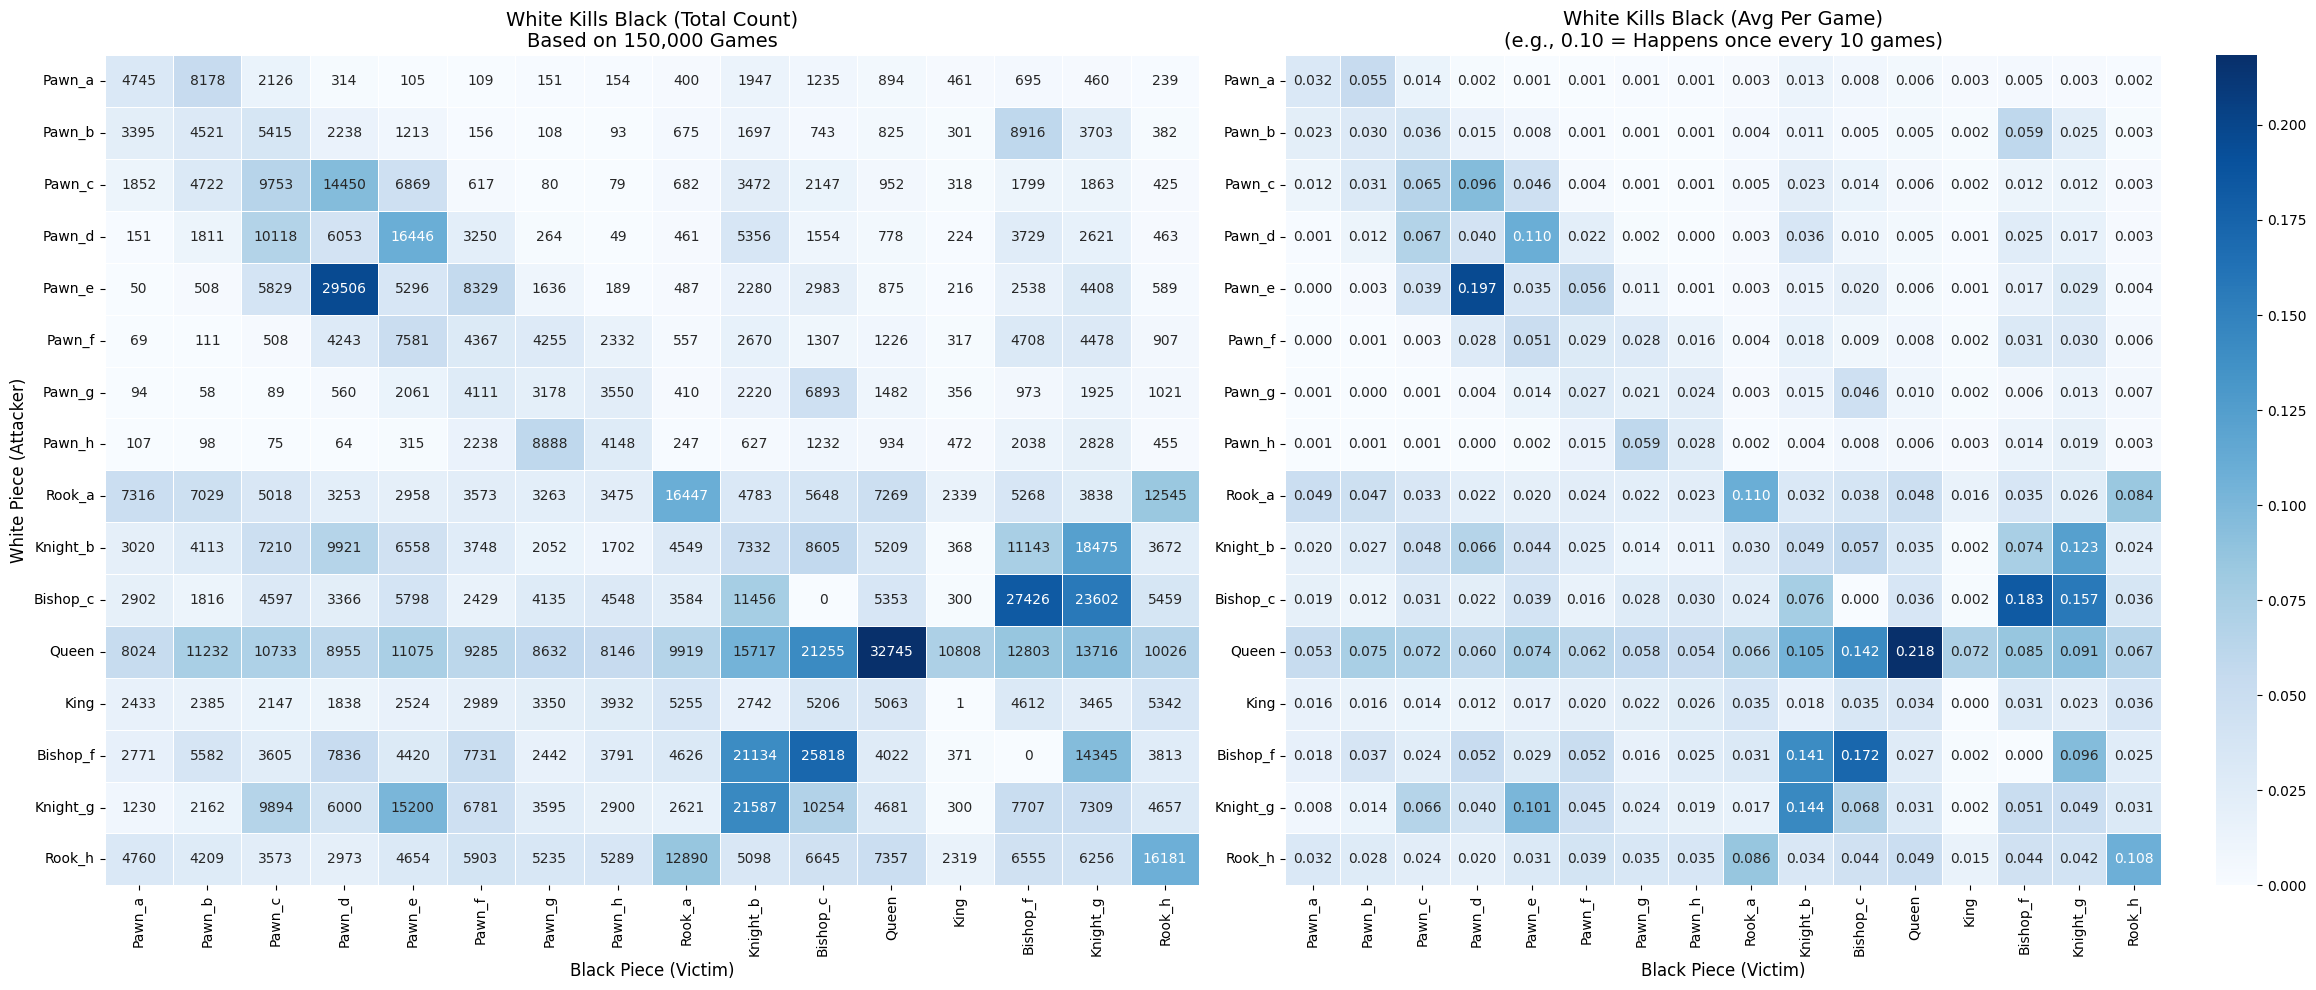

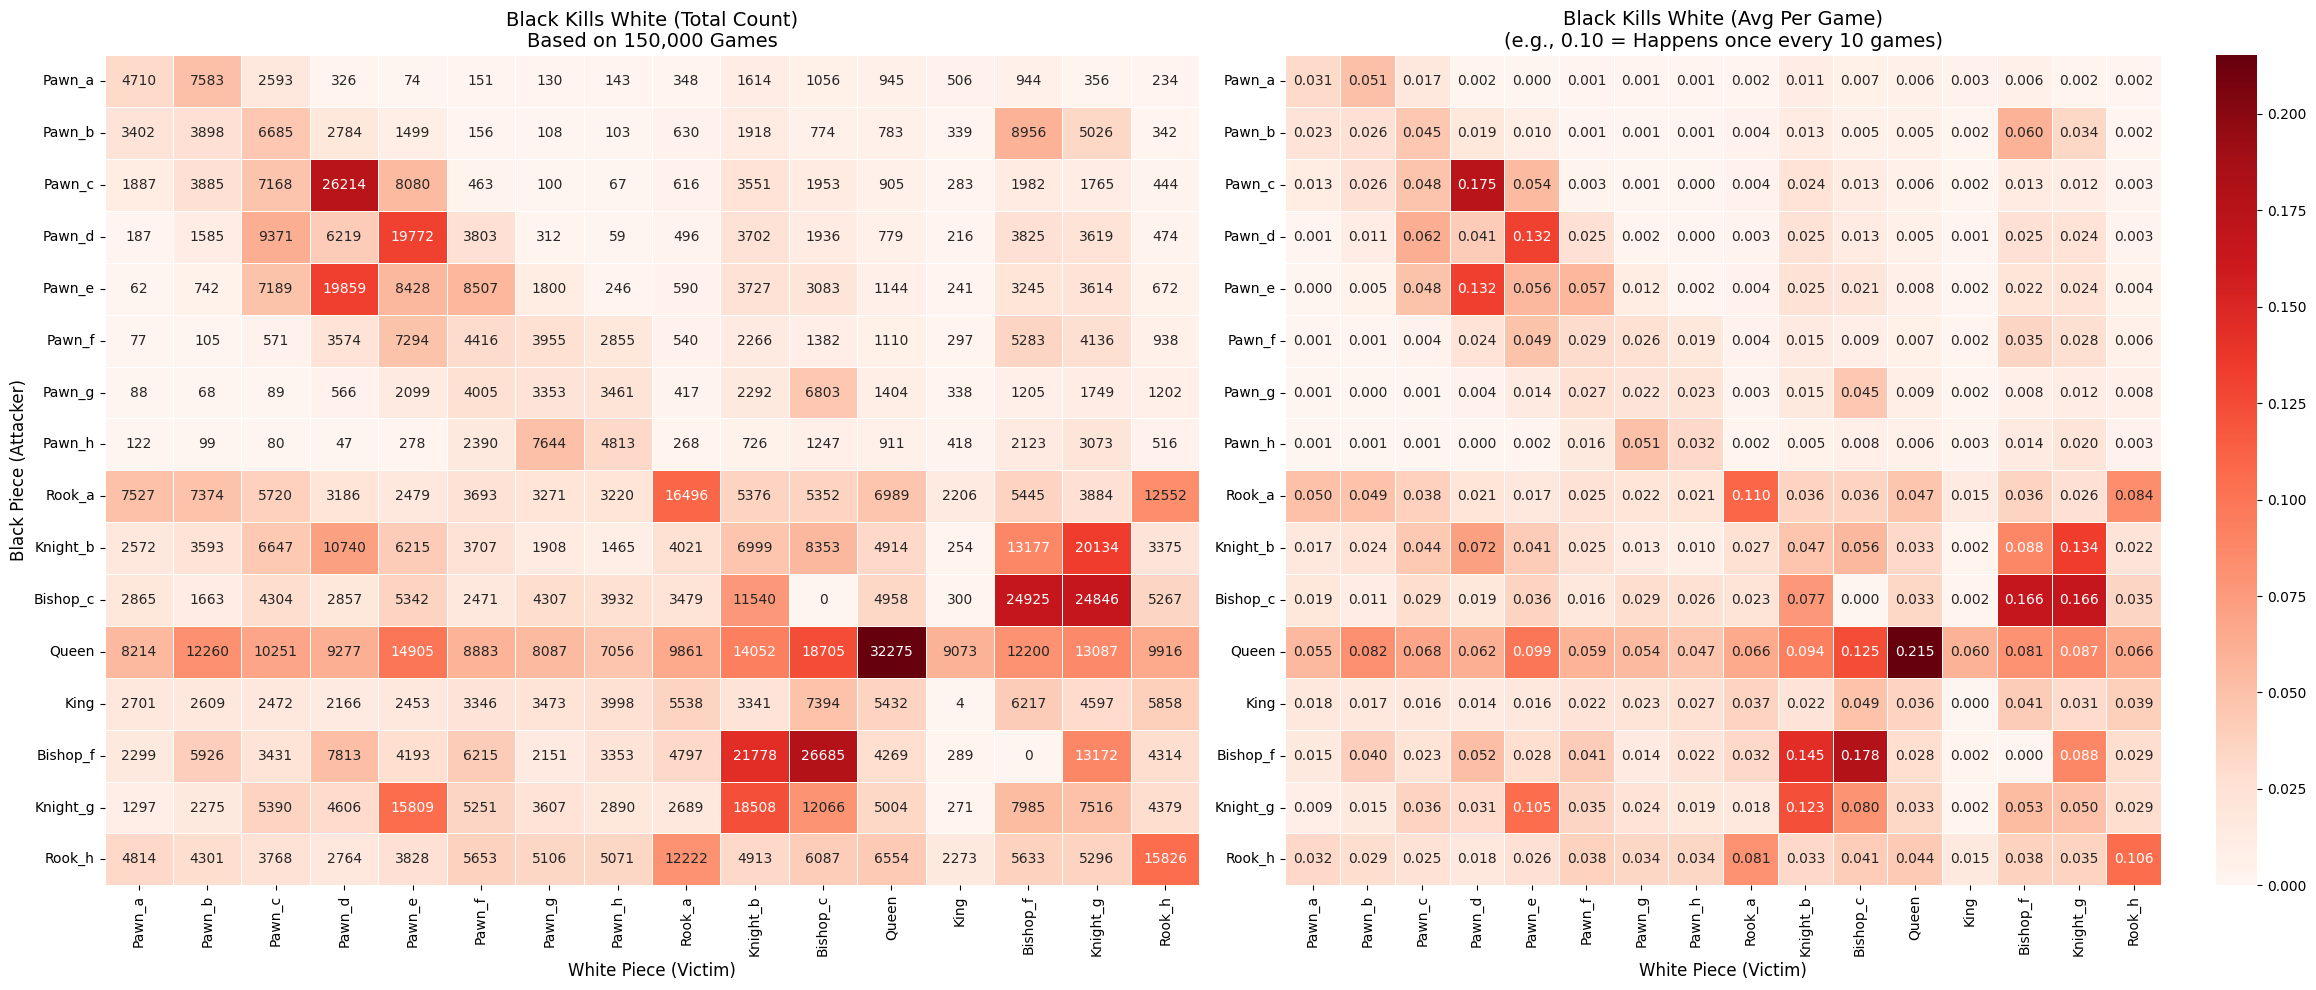

In [2]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# ================= 配置 =================
FILE_PATH = "outcome/chess_killer/checkpoint_v2.json" 
# 如果跑完了全量数据，请改为 "outcome/advanced_analysis/final_matrix.json"

# 定义标准的 16 个棋子顺序 (用于坐标轴排序)
PIECE_ORDER = [
    "Pawn_a", "Pawn_b", "Pawn_c", "Pawn_d", "Pawn_e", "Pawn_f", "Pawn_g", "Pawn_h",
    "Rook_a", "Knight_b", "Bishop_c", "Queen", "King", "Bishop_f", "Knight_g", "Rook_h"
]
# =======================================

def simplify_name(full_id):
    """
    将 'White_Pawn_a_promoted' 简化为 'Pawn_a'
    同时返回颜色 'White'
    """
    parts = full_id.split('_')
    color = parts[0]
    
    # 提取核心身份 (Role + Identity)
    # 例如: Pawn_a, Queen, King, Knight_b
    if len(parts) >= 3:
        # 有 identity (e.g. Pawn_a)
        identity = f"{parts[1]}_{parts[2]}"
    else:
        # 无 identity (e.g. Queen, King)
        identity = parts[1]
        
    return color, identity

def load_and_process_data():
    if not os.path.exists(FILE_PATH):
        print(f"找不到文件: {FILE_PATH}")
        return None, 0

    with open(FILE_PATH, 'r') as f:
        data = json.load(f)
    
    kill_matrix = data['stats']['kill_matrix']
    games_processed = data['games_processed']
    
    records = []
    
    for attacker_full, victims in kill_matrix.items():
        att_color, att_id = simplify_name(attacker_full)
        
        for victim_full, turn_counts in victims.items():
            vic_color, vic_id = simplify_name(victim_full)
            
            # 过滤掉同色击杀（以防万一数据有脏）
            if att_color == vic_color:
                continue
                
            total_kills = sum(turn_counts)
            
            records.append({
                "Attacker_Color": att_color,
                "Attacker_ID": att_id,
                "Victim_Color": vic_color,
                "Victim_ID": vic_id,
                "Count": total_kills
            })
            
    df = pd.DataFrame(records)
    
    # 合并 Promoted 数据 (groupby求和)
    # 因为 simplify_name 已经去掉了 _promoted 后缀，这里只需按 ID group 一下即可
    df = df.groupby(["Attacker_Color", "Attacker_ID", "Victim_Color", "Victim_ID"], as_index=False).sum()
    
    return df, games_processed

def plot_heatmap(df, attacker_color, games_count):
    # 筛选数据
    victim_color = "Black" if attacker_color == "White" else "White"
    subset = df[(df["Attacker_Color"] == attacker_color) & (df["Victim_Color"] == victim_color)]
    
    if subset.empty:
        print(f"没有 {attacker_color} 攻击 {victim_color} 的数据")
        return

    # 创建透视表 (Rows: Attacker, Cols: Victim)
    pivot_count = subset.pivot_table(index="Attacker_ID", columns="Victim_ID", values="Count", fill_value=0)
    
    # 确保 16x16 完整性 (补全缺失的行列)
    pivot_count = pivot_count.reindex(index=PIECE_ORDER, columns=PIECE_ORDER, fill_value=0)
    
    # === 修正点：强制转换为整数 ===
    # Pandas 有时会把 pivot_table 的结果变成 float，导致 fmt="d" 报错
    pivot_count = pivot_count.astype(int)
    # ==========================

    # 计算百分比矩阵 (Per Game)
    # 注意：这里除法会产生 float，下面的 fmt=".3f" 是支持 float 的，所以没问题
    pivot_rate = pivot_count / games_count

    # --- 绘图 ---
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    cmap = "Blues" if attacker_color == "White" else "Reds"
    
    # 图1: 总数量
    # 现在 pivot_count 是纯整数，fmt="d" 不会再报错了
    sns.heatmap(pivot_count, ax=axes[0], cmap=cmap, annot=True, fmt="d", linewidths=.5, cbar=False)
    axes[0].set_title(f"{attacker_color} Kills {victim_color} (Total Count)\nBased on {games_count:,} Games", fontsize=14)
    axes[0].set_ylabel(f"{attacker_color} Piece (Attacker)", fontsize=12)
    axes[0].set_xlabel(f"{victim_color} Piece (Victim)", fontsize=12)

    # 图2: 单局平均值
    # fmt=".3f" 用于保留3位小数
    sns.heatmap(pivot_rate, ax=axes[1], cmap=cmap, annot=True, fmt=".3f", linewidths=.5)
    axes[1].set_title(f"{attacker_color} Kills {victim_color} (Avg Per Game)\n(e.g., 0.10 = Happens once every 10 games)", fontsize=14)
    axes[1].set_ylabel("")
    axes[1].set_xlabel(f"{victim_color} Piece (Victim)", fontsize=12)

    plt.tight_layout()
    plt.show()

# ================= 执行 =================
df, total_games = load_and_process_data()

if df is not None and total_games > 0:
    print(f"当前数据基于 {total_games} 局对局。")
    print("生成可视化图表...")
    
    # 1. 白方杀黑方
    plot_heatmap(df, "White", total_games)
    
    # 2. 黑方杀白方
    plot_heatmap(df, "Black", total_games)
else:
    print("数据加载失败或局数为0。")

# Survival


基于 150000 局数据生成生存曲线...


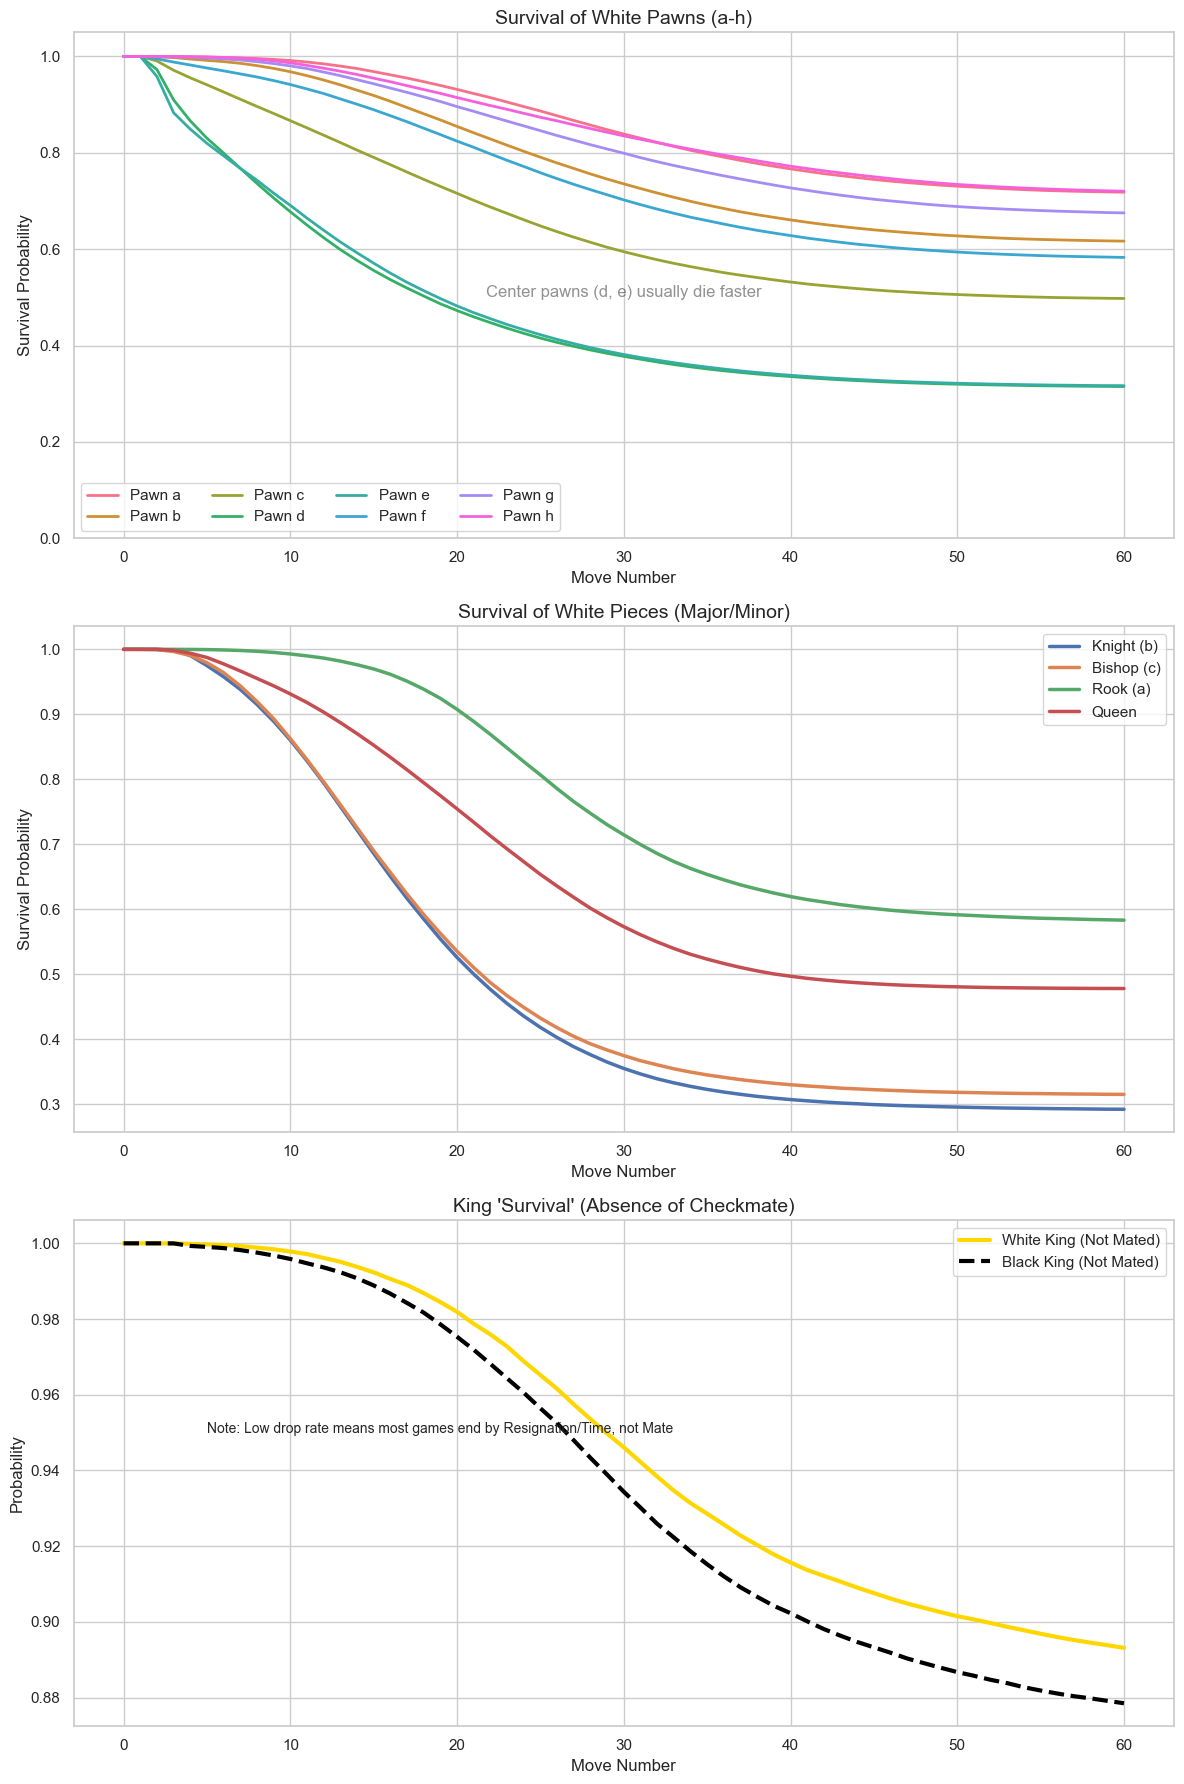

In [3]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# ================= 配置 =================
FILE_PATH = "outcome/chess_killer/checkpoint_v2.json" 
# 或 "outcome/advanced_analysis/final_matrix.json"
MAX_TURN = 75
# =======================================

def get_survival_curve(timeline_data, piece_id, total_games):
    """
    计算指定棋子的生存曲线
    返回: [1.0, 0.99, ..., 0.xx] (长度为 MAX_TURN + 1)
    """
    # 获取该棋子的死亡分布 (长度 76)
    # 需要合并 _promoted 的数据
    base_deaths = np.array(timeline_data.get(piece_id, [0]*(MAX_TURN+1)))
    promoted_id = piece_id + "_promoted"
    promoted_deaths = np.array(timeline_data.get(promoted_id, [0]*(MAX_TURN+1)))
    
    total_deaths_per_turn = base_deaths + promoted_deaths
    
    # 计算累积死亡数
    cumulative_deaths = np.cumsum(total_deaths_per_turn)
    
    # 计算存活数
    survivors = total_games - cumulative_deaths
    
    # 计算存活率
    survival_rates = survivors / total_games
    
    # 在最前面插入 1.0 (第0回合，大家都在)
    # 此时数组长度变为 77 (索引0=0回合, 索引1=1回合...)
    return np.insert(survival_rates, 0, 1.0)

def plot_survival_curves():
    if not os.path.exists(FILE_PATH):
        print("数据文件不存在。")
        return

    with open(FILE_PATH, 'r') as f:
        data = json.load(f)
        
    timeline = data['stats']['death_timeline']
    games = data['games_processed']
    
    if games == 0:
        print("处理局数为0，无法绘图。")
        return

    print(f"基于 {games} 局数据生成生存曲线...")

    # 设置绘图风格
    sns.set_theme(style="whitegrid")
    
    # 定义 X 轴 (0 到 75)
    x_axis = np.arange(0, MAX_TURN + 2) # +2 是因为我们在get_survival_curve里插了一个0回合，且原数组长76
    # 实际上我们只画前75回合比较好看，最后一项是76+
    plot_limit = 60 # 为了图表清晰，我们只画前 60 回合，因为后面变化平缓
    x_axis = np.arange(0, plot_limit + 1)

    fig, axes = plt.subplots(3, 1, figsize=(12, 18))
    
    # --- 图1: 白方所有兵的生存大比拼 ---
    ax = axes[0]
    pawns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    colors = sns.color_palette("husl", 8)
    
    for i, p_file in enumerate(pawns):
        pid = f"White_Pawn_{p_file}"
        curve = get_survival_curve(timeline, pid, games)
        ax.plot(x_axis, curve[:plot_limit+1], label=f"Pawn {p_file}", color=colors[i], linewidth=2)
        
    ax.set_title("Survival of White Pawns (a-h)", fontsize=14)
    ax.set_ylabel("Survival Probability")
    ax.set_xlabel("Move Number")
    ax.set_ylim(0, 1.05)
    ax.legend(loc="lower left", ncol=4)
    ax.text(plot_limit/2, 0.5, "Center pawns (d, e) usually die faster", ha='center', alpha=0.5)

    # --- 图2: 白方不同兵种的生存率 (车马象后) ---
    ax = axes[1]
    pieces = [
        ("White_Knight_b", "Knight (b)"),
        ("White_Bishop_c", "Bishop (c)"),
        ("White_Rook_a",   "Rook (a)"),
        ("White_Queen",    "Queen")
    ]
    
    for pid, label in pieces:
        curve = get_survival_curve(timeline, pid, games)
        ax.plot(x_axis, curve[:plot_limit+1], label=label, linewidth=2.5)
        
    ax.set_title("Survival of White Pieces (Major/Minor)", fontsize=14)
    ax.set_ylabel("Survival Probability")
    ax.set_xlabel("Move Number")
    ax.legend()
    
    # --- 图3: 双方王的生存率 (即: 比赛未分胜负或未被将杀的概率) ---
    # 注意：这里的“死”代表被 Checkmate。
    # 实际上这更接近 "Game Not Lost by Checkmate Curve"
    # 如果大部分游戏是超时或投降结束的，这个曲线可能不会降到0
    ax = axes[2]
    w_king_curve = get_survival_curve(timeline, "White_King", games)
    b_king_curve = get_survival_curve(timeline, "Black_King", games)
    
    ax.plot(x_axis, w_king_curve[:plot_limit+1], label="White King (Not Mated)", color="gold", linewidth=3)
    ax.plot(x_axis, b_king_curve[:plot_limit+1], label="Black King (Not Mated)", color="black", linewidth=3, linestyle="--")
    
    ax.set_title("King 'Survival' (Absence of Checkmate)", fontsize=14)
    ax.set_ylabel("Probability")
    ax.set_xlabel("Move Number")
    ax.legend()
    ax.text(5, 0.95, "Note: Low drop rate means most games end by Resignation/Time, not Mate", fontsize=10)

    plt.tight_layout()
    plt.show()

# 运行
plot_survival_curves()

# Death Time and Kill Time

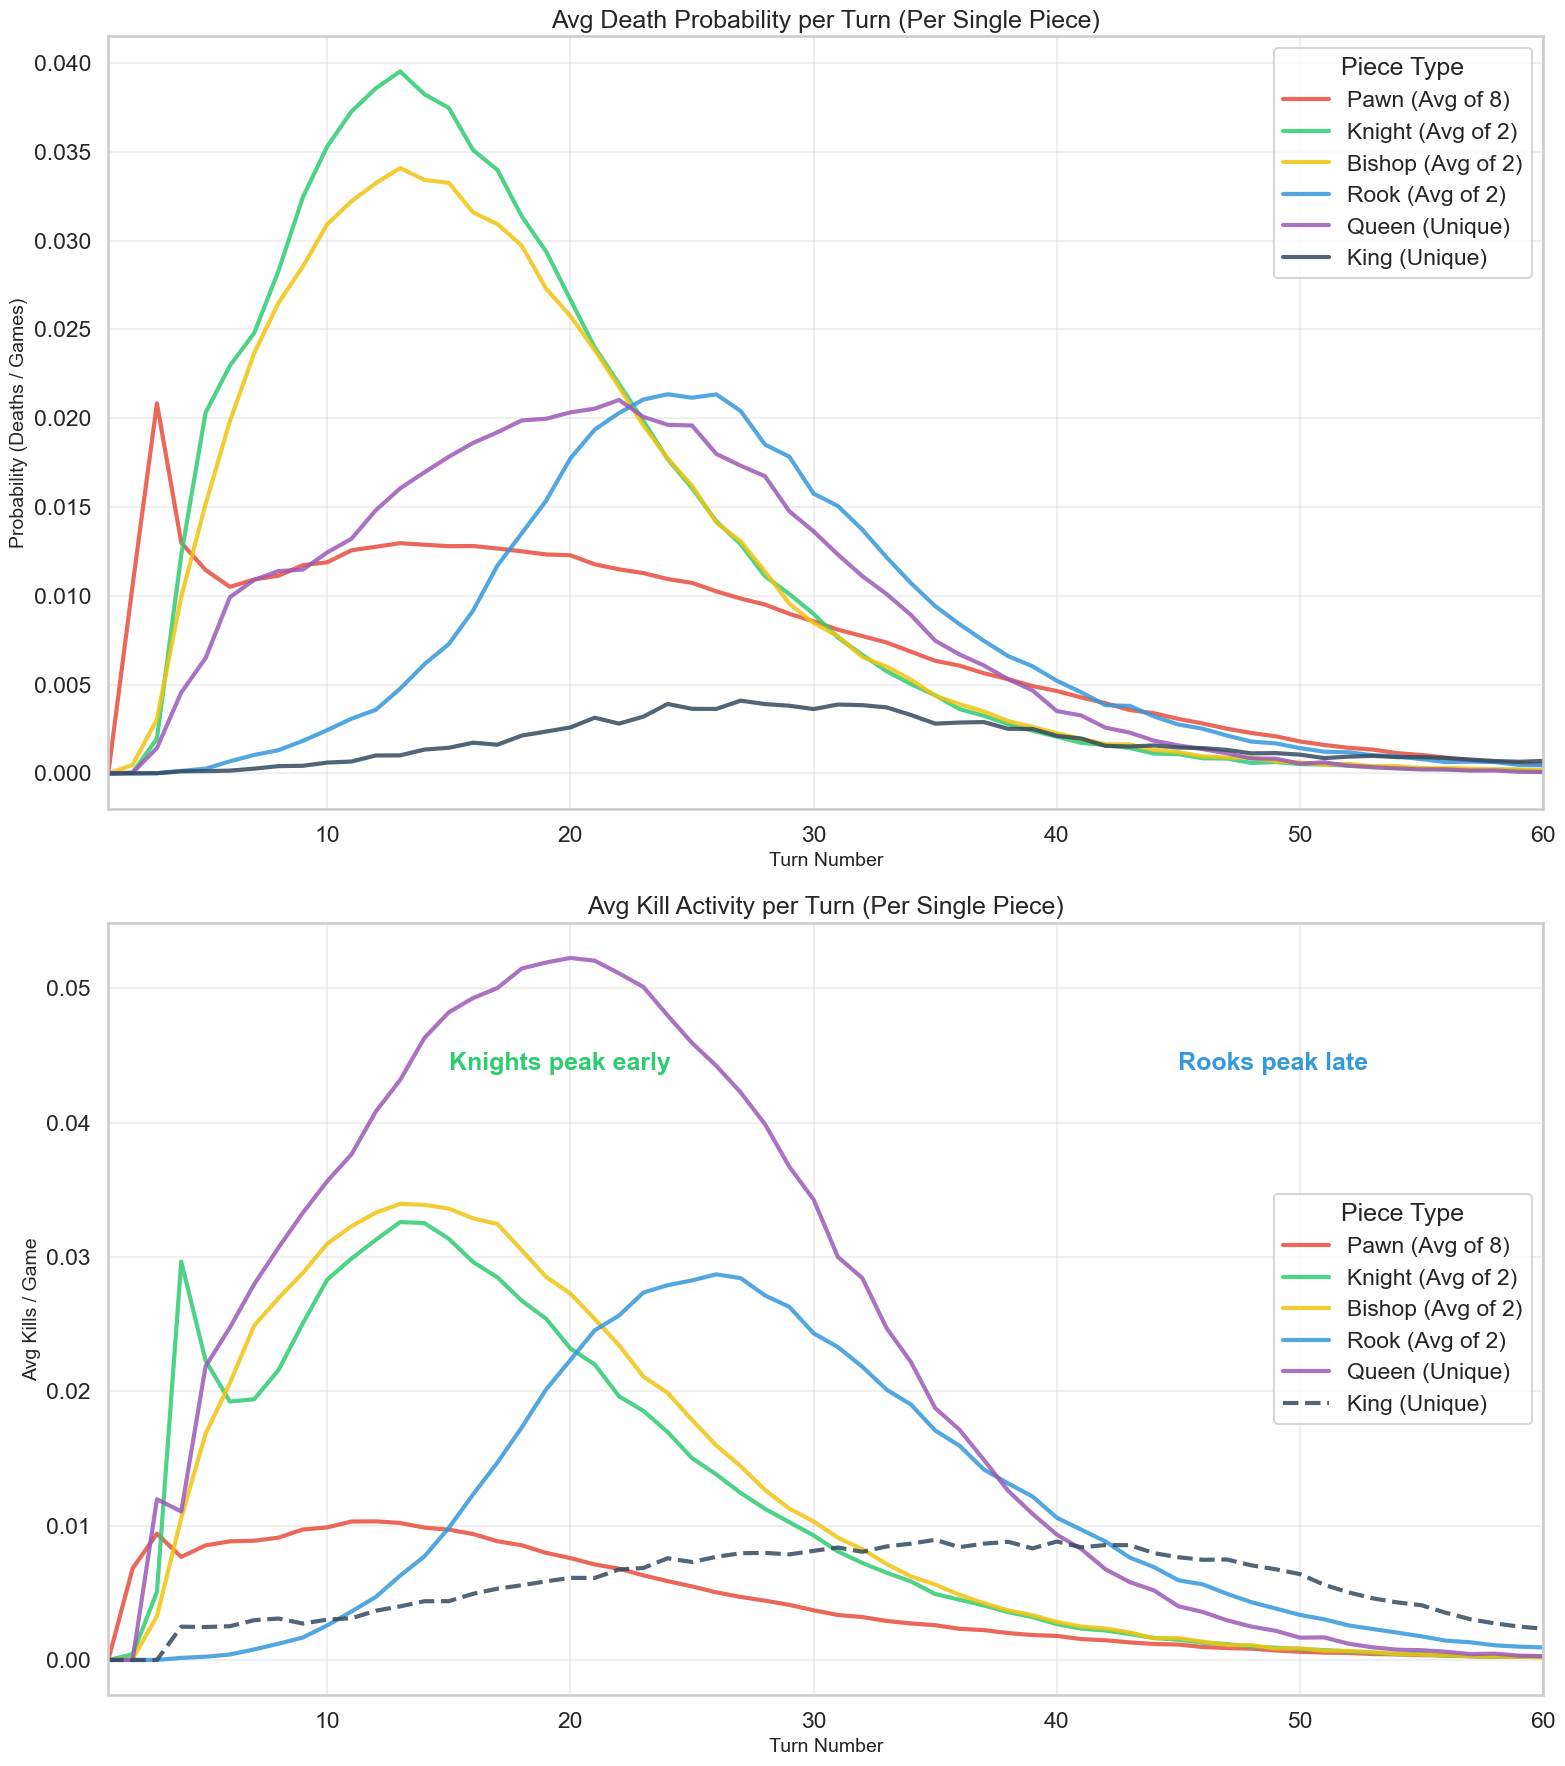

In [5]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# ================= 配置区域 =================
# 请确保路径正确
FILE_PATH = "outcome/chess_killer/checkpoint_v2.json" 
DISPLAY_TURNS = 60  # 展示前60回合
# ===========================================

def load_data():
    if not os.path.exists(FILE_PATH):
        print(f"错误: 找不到文件 {FILE_PATH}")
        return None
    with open(FILE_PATH, 'r') as f:
        return json.load(f)

def get_aggregated_trend(source_dict, piece_role, piece_count, display_turns):
    """
    聚合特定兵种的数据，并计算"单兵种平均值"
    
    Args:
        source_dict: 原始数据字典 (kill_matrix 或 death_timeline)
        piece_role: 角色名称片段 (e.g. "Pawn", "Knight")
        piece_count: 该兵种初始数量 (e.g. Pawn=8, Knight=2)
    Returns:
        np.array: 长度为 display_turns 的数组
    """
    total_trend = np.zeros(display_turns)
    
    # 1. 动态查找所有相关的 Key
    # 只要 Key 中包含 "White_{piece_role}" 即可 (兼容 _promoted)
    # 这里我们默认分析白方 (White)，因为黑白通常是对称的，看一方更清晰
    target_prefix = f"White_{piece_role}"
    
    # 区分处理 kill_matrix (3D) 和 death_timeline (2D)
    is_kill_matrix = isinstance(list(source_dict.values())[0], dict) if source_dict else False
    
    found_keys = 0
    
    for key, value in source_dict.items():
        if target_prefix in key:
            found_keys += 1
            current_trend = np.zeros(display_turns)
            
            if is_kill_matrix:
                # Value 是 {Victim: [counts]}
                # 我们需要把该棋子对"所有人"的击杀加起来
                for victim_counts in value.values():
                    counts = np.array(victim_counts)
                    length = min(len(counts), display_turns)
                    current_trend[:length] += counts[:length]
            else:
                # Value 是 [counts] (Death timeline)
                counts = np.array(value)
                length = min(len(counts), display_turns)
                current_trend[:length] += counts[:length]
            
            total_trend += current_trend

    # 2. 平均化 (除以该兵种的个体数量)
    # 例如：把 8 个兵的总和除以 8，得到"平均一个兵"的数据
    if piece_count > 0:
        total_trend = total_trend / piece_count
        
    return total_trend

# ================= 主绘图逻辑 =================

data_wrapper = load_data()

if data_wrapper:
    stats = data_wrapper['stats']
    death_timeline = stats['death_timeline']
    kill_matrix = stats['kill_matrix']
    games_count = data_wrapper['games_processed']
    
    if games_count == 0:
        print("错误：对局数为 0")
        exit()

    # 定义兵种及其数量
    pieces_config = [
        # (Role Name, Count, Color, Label)
        ("Pawn",   8, "#e74c3c", "Pawn (Avg of 8)"),
        ("Knight", 2, "#2ecc71", "Knight (Avg of 2)"),
        ("Bishop", 2, "#f1c40f", "Bishop (Avg of 2)"),
        ("Rook",   2, "#3498db", "Rook (Avg of 2)"),
        ("Queen",  1, "#9b59b6", "Queen (Unique)"),
        ("King",   1, "#34495e", "King (Unique)") 
    ]
    
    sns.set_theme(style="whitegrid", context="talk")
    x_axis = np.arange(1, DISPLAY_TURNS + 1)
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 18))
    
    # --- 图 1: 单个棋子的平均死亡分布 ---
    ax1 = axes[0]
    for role, count, color, label in pieces_config:
        # 获取聚合数据
        trend = get_aggregated_trend(death_timeline, role, count, DISPLAY_TURNS)
        
        # 归一化到"每局概率" (除以总局数)
        # 含义：平均每局，这个棋子在第 T 回合死的概率
        trend_per_game = trend / games_count
        
        ax1.plot(x_axis, trend_per_game, label=label, color=color, linewidth=3, alpha=0.85)
    
    ax1.set_title("Avg Death Probability per Turn (Per Single Piece)", fontsize=18)
    ax1.set_ylabel("Probability (Deaths / Games)", fontsize=14)
    ax1.set_xlabel("Turn Number", fontsize=14)
    ax1.legend(title="Piece Type")
    ax1.set_xlim(1, DISPLAY_TURNS)
    ax1.grid(True, alpha=0.3)

    # --- 图 2: 单个棋子的平均击杀分布 ---
    ax2 = axes[1]
    for role, count, color, label in pieces_config:
        # 获取聚合数据
        trend = get_aggregated_trend(kill_matrix, role, count, DISPLAY_TURNS)
        
        # 归一化
        trend_per_game = trend / games_count
        
        # King 的击杀数通常极低，可以画但不明显，或者用虚线
        ls = "--" if role == "King" else "-"
        
        ax2.plot(x_axis, trend_per_game, label=label, color=color, linewidth=3, alpha=0.85, linestyle=ls)
        
    ax2.set_title("Avg Kill Activity per Turn (Per Single Piece)", fontsize=18)
    ax2.set_ylabel("Avg Kills / Game", fontsize=14)
    ax2.set_xlabel("Turn Number", fontsize=14)
    ax2.legend(title="Piece Type")
    ax2.set_xlim(1, DISPLAY_TURNS)
    ax2.grid(True, alpha=0.3)
    
    # 添加注解：解释 Knight 和 Rook 的交叉
    ax2.text(15, ax2.get_ylim()[1]*0.8, "Knights peak early", color="#2ecc71", fontweight='bold')
    ax2.text(45, ax2.get_ylim()[1]*0.8, "Rooks peak late", color="#3498db", fontweight='bold')

    plt.tight_layout()
    plt.show()
    
else:
    print("无法加载数据。")

## In-group compare

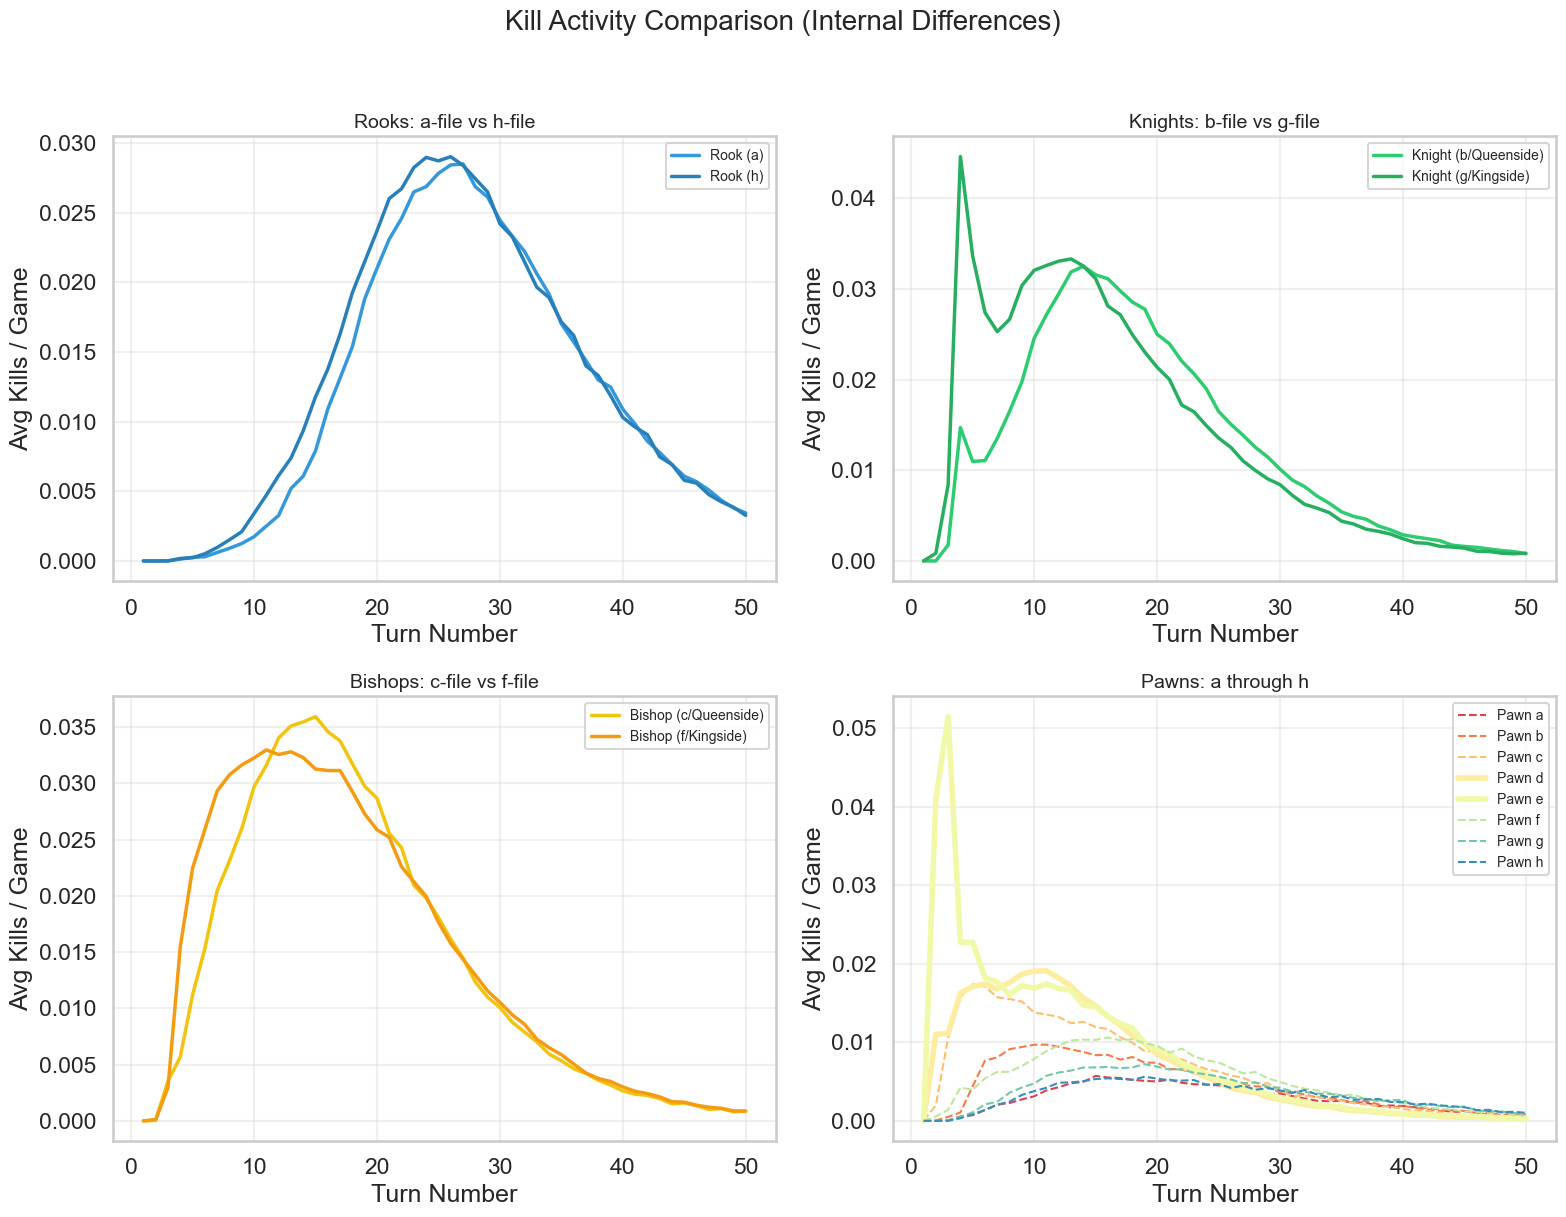

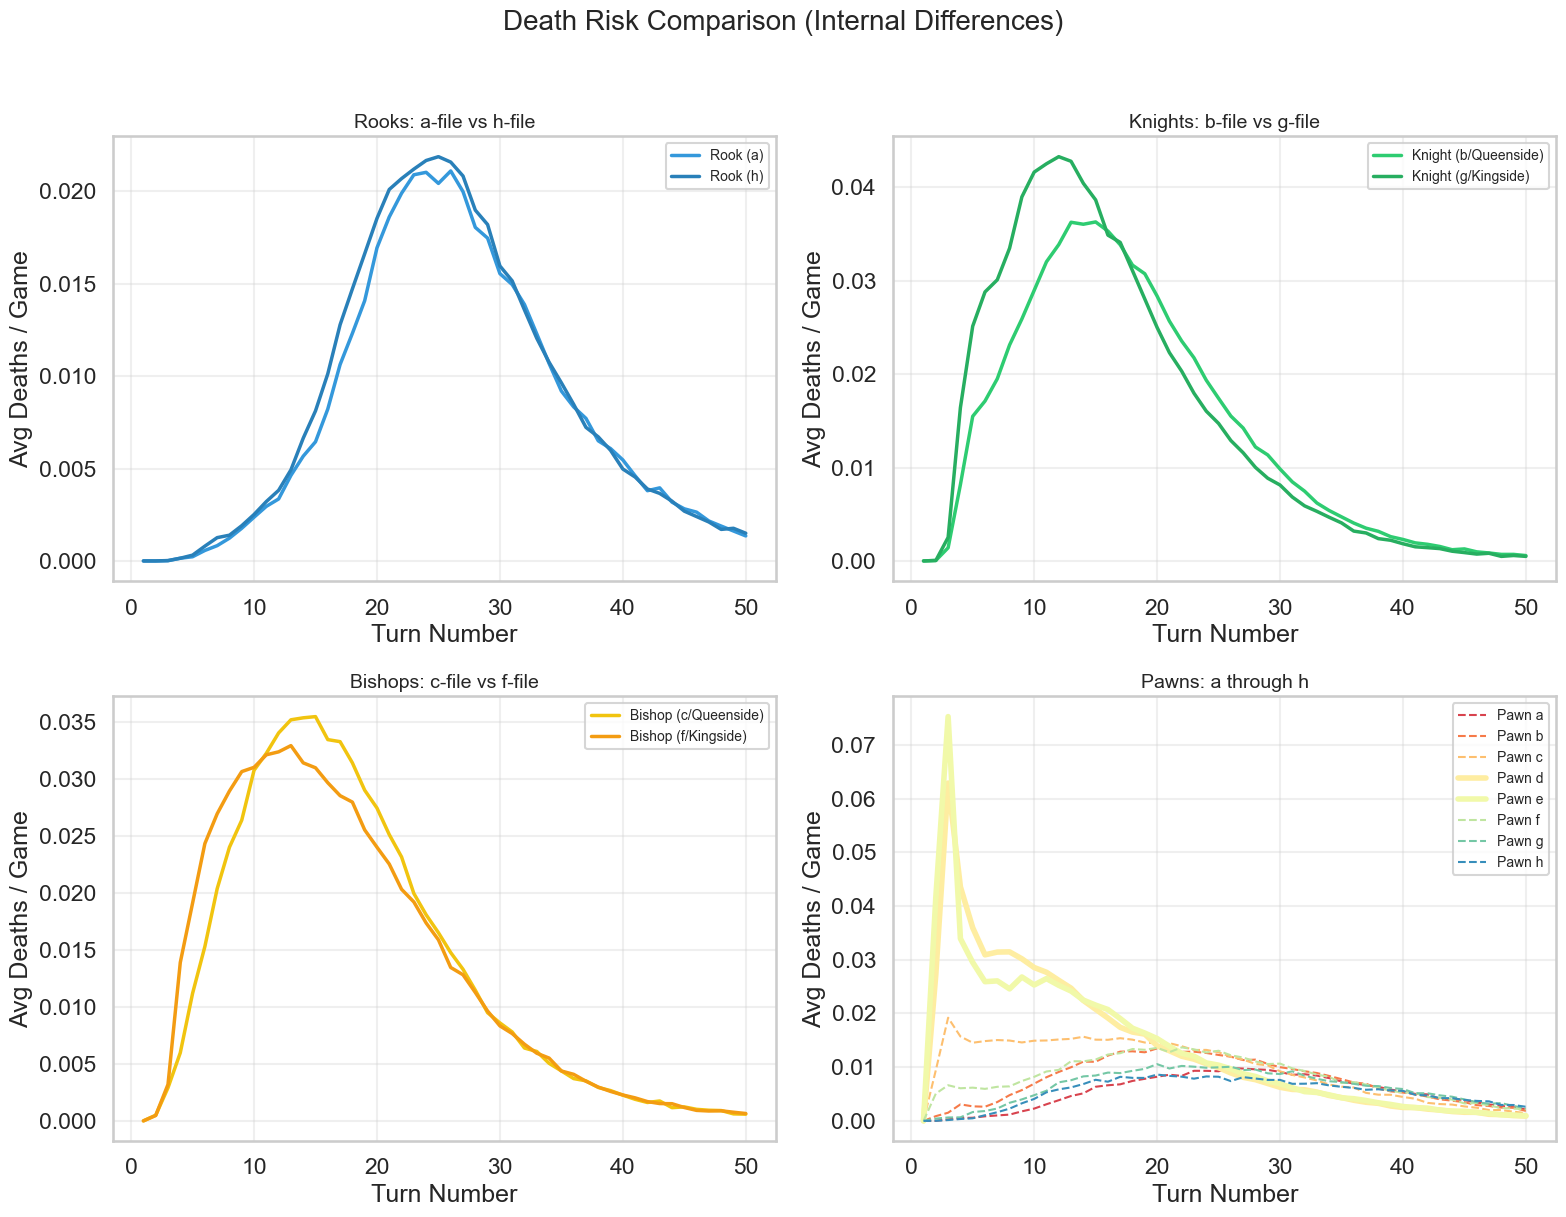

In [7]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# ================= 配置 =================
FILE_PATH = "outcome/chess_killer/checkpoint_v2.json"
DISPLAY_TURNS = 50 # 聚焦前50回合，差异最明显
# =======================================

def load_data():
    if not os.path.exists(FILE_PATH):
        print(f"错误: 找不到文件 {FILE_PATH}")
        return None
    with open(FILE_PATH, 'r') as f:
        return json.load(f)

def get_piece_trend(stats, piece_id, metric_type, display_turns):
    """
    获取特定棋子(包括其升变体)的数据
    metric_type: 'kills' or 'deaths'
    """
    total_trend = np.zeros(display_turns)
    ids_to_check = [piece_id, piece_id + "_promoted"]
    
    for uid in ids_to_check:
        if metric_type == 'kills':
            # Kill Matrix: {Victim: [counts]} -> Sum all victims
            if uid in stats['kill_matrix']:
                for counts in stats['kill_matrix'][uid].values():
                    arr = np.array(counts)
                    length = min(len(arr), display_turns)
                    total_trend[:length] += arr[:length]
        else:
            # Death Timeline: [counts]
            if uid in stats['death_timeline']:
                arr = np.array(stats['death_timeline'][uid])
                length = min(len(arr), display_turns)
                total_trend[:length] += arr[:length]
                
    return total_trend

def plot_group_comparison(stats, games_count, metric_type):
    """
    绘制 2x2 对比图
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    x_axis = np.arange(1, DISPLAY_TURNS + 1)
    
    # 定义比较组
    comparisons = [
        # (Title, Ax, Piece_List, Colors)
        ("Rooks: a-file vs h-file", axes[0, 0], 
         [("White_Rook_a", "Rook (a)"), ("White_Rook_h", "Rook (h)")], ["#3498db", "#2980b9"]),
         
        ("Knights: b-file vs g-file", axes[0, 1],
         [("White_Knight_b", "Knight (b/Queenside)"), ("White_Knight_g", "Knight (g/Kingside)")], ["#2ecc71", "#27ae60"]),
         
        ("Bishops: c-file vs f-file", axes[1, 0],
         [("White_Bishop_c", "Bishop (c/Queenside)"), ("White_Bishop_f", "Bishop (f/Kingside)")], ["#f1c40f", "#f39c12"]),
         
        ("Pawns: a through h", axes[1, 1],
         [(f"White_Pawn_{char}", f"Pawn {char}") for char in "abcdefgh"], None) # 兵单独处理颜色
    ]
    
    y_label = "Avg Kills / Game" if metric_type == 'kills' else "Avg Deaths / Game"
    title_prefix = "Kill Activity" if metric_type == 'kills' else "Death Risk"
    
    for title, ax, pieces, manual_colors in comparisons:
        # 特殊处理兵的颜色 (渐变色)
        if "Pawns" in title:
            palette = sns.color_palette("Spectral", 8) # 8色光谱
        else:
            palette = manual_colors
            
        for i, (pid, label) in enumerate(pieces):
            trend = get_piece_trend(stats, pid, metric_type, DISPLAY_TURNS)
            norm_trend = trend / games_count # 归一化为单局概率
            
            # 样式微调
            lw = 2.5
            ls = "-"
            color = palette[i]
            
            # 如果是兵，把 d, e 兵加粗，a, h 兵变细
            if "Pawn" in title:
                if "d" in label or "e" in label:
                    lw = 4
                    ls = "-" 
                elif "a" in label or "h" in label:
                    lw = 1.5
                    ls = "--"
            
            ax.plot(x_axis, norm_trend, label=label, color=color, linewidth=lw, linestyle=ls)
        
        ax.set_title(title, fontsize=14)
        ax.set_xlabel("Turn Number")
        ax.set_ylabel(y_label)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
        
    plt.suptitle(f"{title_prefix} Comparison (Internal Differences)", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

# ================= 执行 =================

data_wrapper = load_data()

if data_wrapper:
    stats = data_wrapper['stats']
    games = data_wrapper['games_processed']
    
    if games > 0:
        # 1. 绘制击杀活跃度对比 (进攻端)
        plot_group_comparison(stats, games, 'kills')
        
        # 2. 绘制死亡风险对比 (防守端)
        plot_group_comparison(stats, games, 'deaths')
    else:
        print("局数为0")

## RMK:
马的击杀尖峰和兵的阵亡尖峰重叠。

d兵只有死亡尖峰，没有击杀尖峰。

g马的击杀尖峰十分显著，b马非常短小。